<a href="https://colab.research.google.com/github/ThaliSouza2017/analise_exploratoria/blob/master/Previs%C3%A3o_de_Custos_M%C3%A9dicos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Equação do Negócio

Somos um plano de saúde e queremos prever com uma certa taxa de acurácia, quais serão os pacientes que no futuro terão mais gastos com saúde.

##Parte 1 - Fazendo a leitura do dataset

In [0]:
#importando as bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as pl
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
output_notebook()
import scipy.special
from bokeh.layouts import gridplot
from bokeh.plotting import figure, show, output_file
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.ensemble import RandomForestRegressor

In [3]:
#importando o dataset que utilizaremos na análise
from google.colab import files
uploaded = files.upload()

Saving some_medical_insurance_costs.csv to some_medical_insurance_costs.csv


In [0]:
#criando o dataframe do dataset
df = pd.read_csv('some_medical_insurance_costs.csv')

In [5]:
#lendo as primeiras linhas da tabela para verificar se o carregamento funcionou
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19.0,female,27.900,0,yes,southwest,16884.92400
1,18.0,male,33.770,1,no,southeast,1725.55230
2,28.0,male,33.000,3,no,southeast,4449.46200
3,33.0,male,22.705,0,no,northwest,21984.47061
4,32.0,male,28.880,0,no,northwest,3866.85520


In [6]:
#vertificando os tipos de dados que existem nesse dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 7 columns):
age         1338 non-null float64
sex         1340 non-null object
bmi         1340 non-null float64
children    1340 non-null int64
smoker      1339 non-null object
region      1339 non-null object
charges     1340 non-null float64
dtypes: float64(3), int64(1), object(3)
memory usage: 73.4+ KB


In [7]:
#checando se existe algum dado null na tabela
df.isna().sum()

age         2
sex         0
bmi         0
children    0
smoker      1
region      1
charges     0
dtype: int64

In [8]:
#como existem poucos dados nulos na tabela, vamos optar por retirar esses dados
df = df.dropna()
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [9]:
#renomeando as colunas para ficar de mais fácil entendimento
df.columns = ['idade',	'genero', 'IMC', 'filhos', 'fumante', 'regiao', 'custos']
df.head(0)

,idade,genero,IMC,filhos,fumante,regiao,custos


## Parte 2 - Análise Exploratória 

In [10]:
#checando a consistência dos dados
df.describe().T

,count,mean,std,min,25%,50%,75%,max
idade,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
IMC,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
filhos,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
custos,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


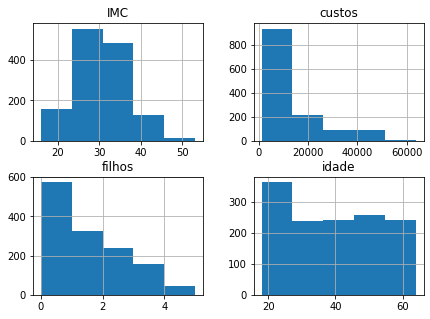

In [11]:
#agora, vamos plotar um histograma para verificar a distribuicao dos dados 
df.hist(bins = 5, figsize=(7,5))
pl.show()

In [0]:
#transformando as variáveis categóricas em númericas, para incluí-las na modelagem da regressão

#gênero
le = LabelEncoder()
le.fit(df.genero.drop_duplicates()) 
df.genero = le.transform(df.genero)

#fumante ou não fumante
le.fit(df.fumante.drop_duplicates()) 
df.fumante = le.transform(df.fumante)

#região
le.fit(df.regiao.drop_duplicates()) 
df.regiao = le.transform(df.regiao)

In [13]:
#vamos ver como ficaram as novas variáveis
df.head()

,idade,genero,IMC,filhos,fumante,regiao,custos
0,19.0,0,27.900,0,1,3,16884.92400
1,18.0,1,33.770,1,0,2,1725.55230
2,28.0,1,33.000,3,0,2,4449.46200
3,33.0,1,22.705,0,0,1,21984.47061
4,32.0,1,28.880,0,0,1,3866.85520


In [14]:
#verificando a correlação entre as variáveis independentes e a variável dependente
df.corr()['custos']

idade      0.299008
genero     0.057292
IMC        0.198341
filhos     0.067998
fumante    0.787251
regiao    -0.006208
custos     1.000000
Name: custos, dtype: float64

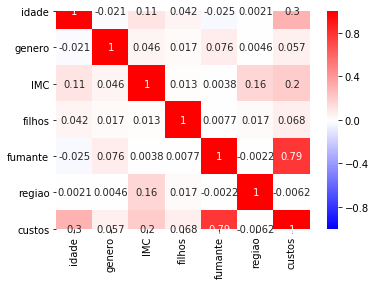

In [15]:
#plotando a correlação entre as variáveis independentes e a variável dependente
sns.heatmap(df.corr(), cmap='bwr', vmax=1, vmin=-1,center=0, square=True, annot=True)

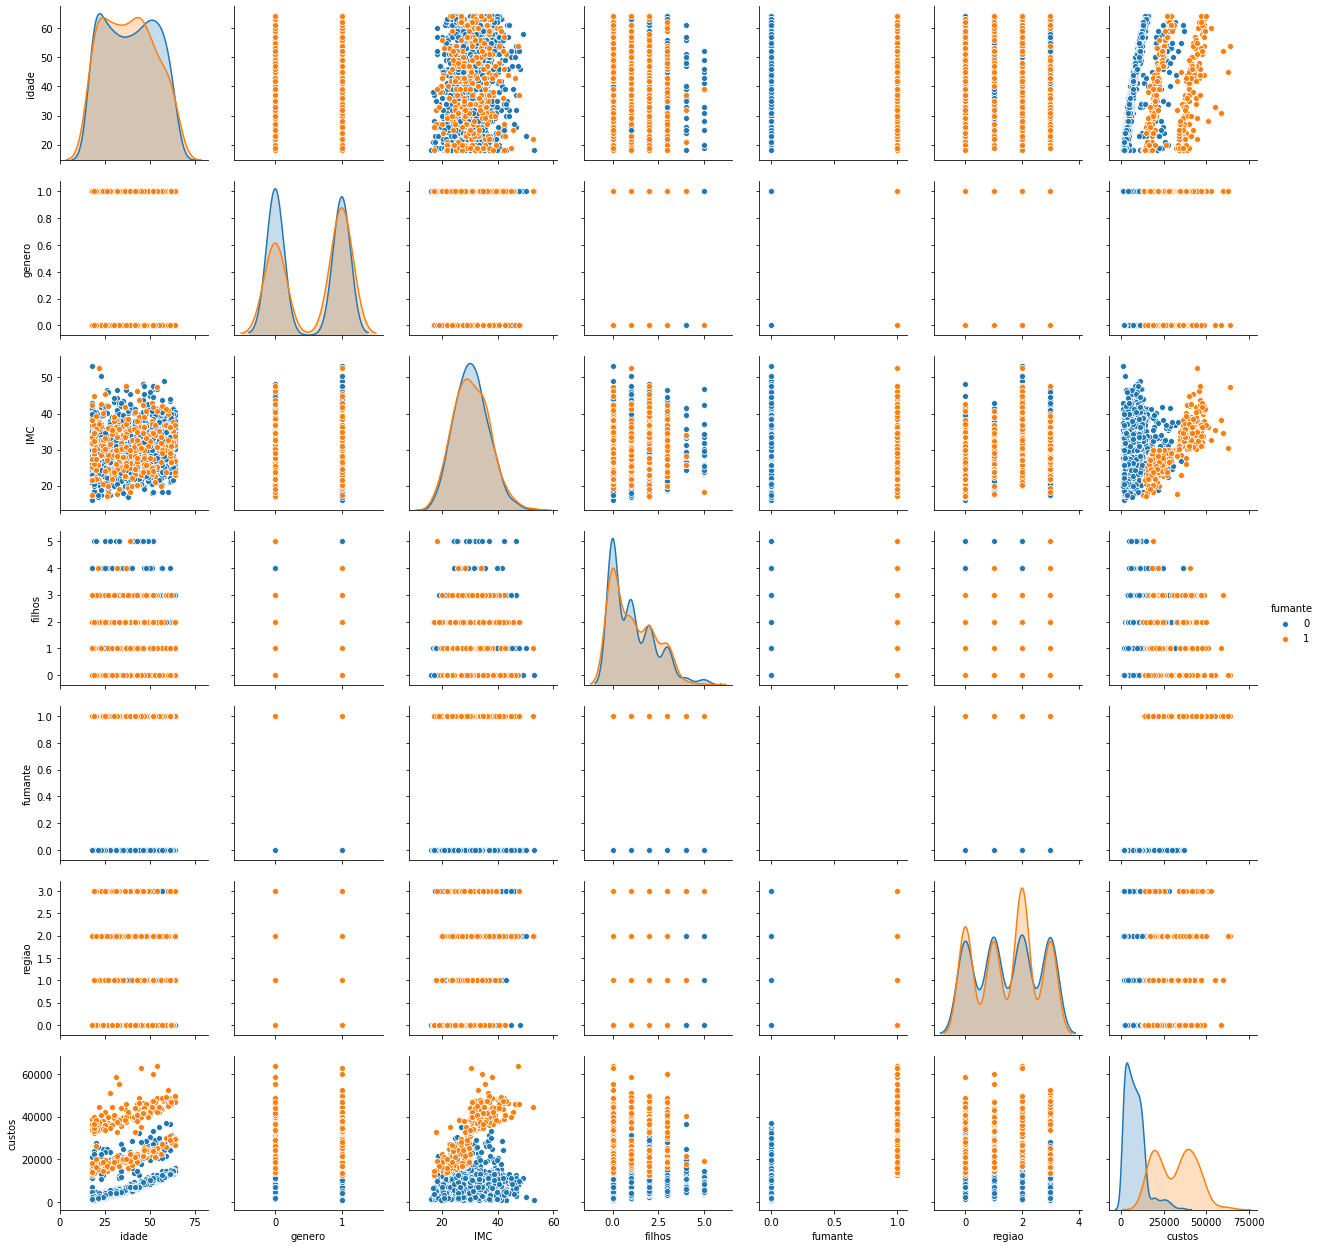

In [16]:
#plotando a correlação entre as variáveis
sns.pairplot(df, hue = 'fumante')

Text(0.5, 1.0, 'Valores gastos por não-fumantes')

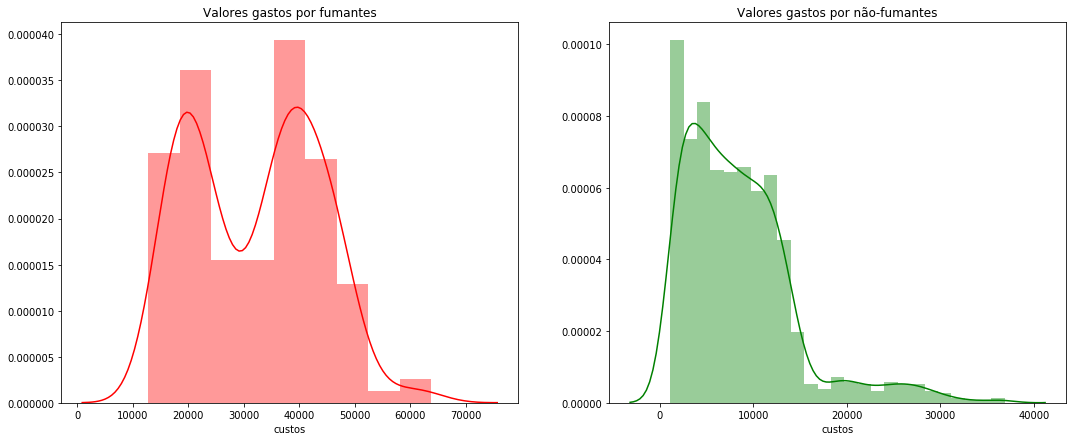

In [17]:
#plotando a distribuição dos valores gastos das pessoas fumantes
f = pl.figure(figsize=(18,7))

ax = f.add_subplot(121)
sns.distplot(df[(df.fumante == 1)]["custos"],color='r',ax=ax)
ax.set_title('Valores gastos por fumantes')

ax = f.add_subplot(122)
sns.distplot(df[(df.fumante == 0)]["custos"],color='g',ax=ax)
ax.set_title('Valores gastos por não-fumantes')

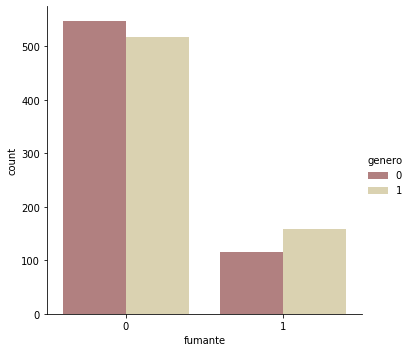

In [18]:
#plotando pessoas fumantes por genero, lembrando que o 0 = mulher e 1 = homem
sns.catplot(x='fumante', kind='count', hue = 'genero', palette = 'pink', data=df)

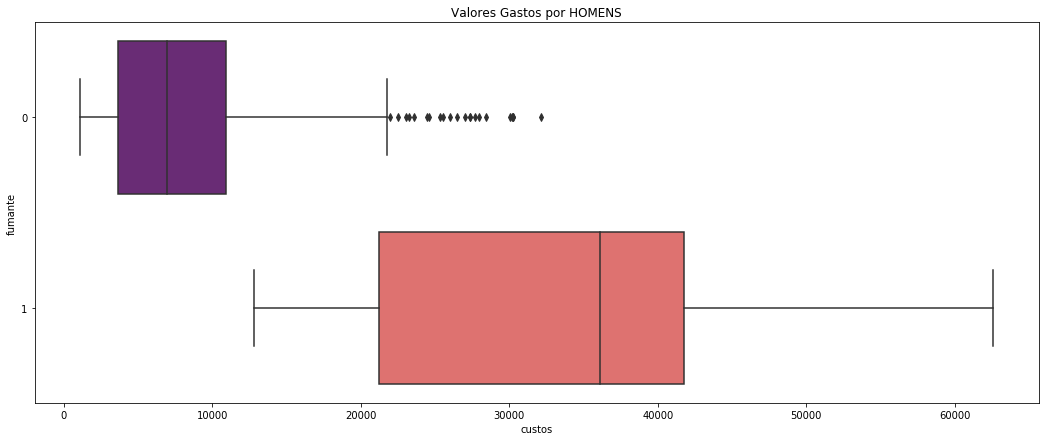

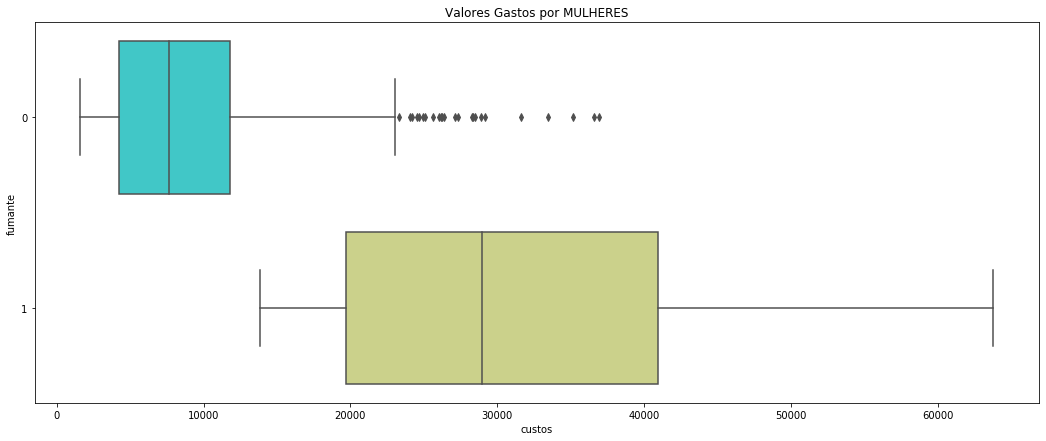

In [19]:
#plotando um boxplot com essa mesma lógica
pl.figure(figsize=(18,7))
pl.title("Valores Gastos por HOMENS")
sns.boxplot(y="fumante", x="custos", data = df[(df.genero == 1)] , orient="h", palette = 'magma')

pl.figure(figsize=(18,7))
pl.title("Valores Gastos por MULHERES")
sns.boxplot(y="fumante", x="custos", data = df[(df.genero == 0)] , orient="h", palette = 'rainbow')


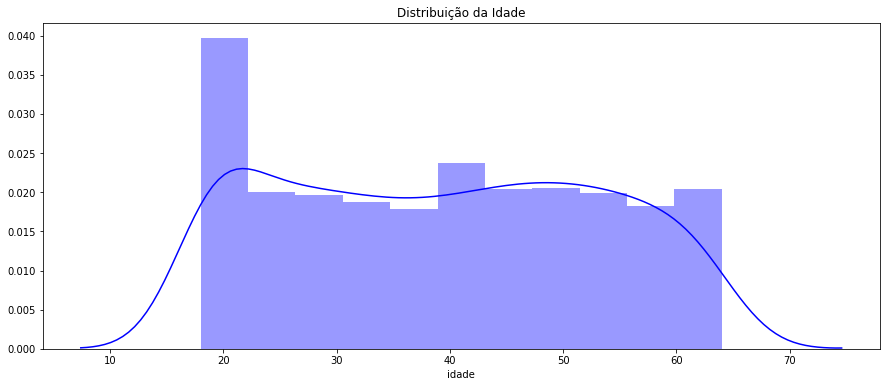

In [20]:
pl.figure(figsize=(15,6))
pl.title("Distribuição da Idade")
ax = sns.distplot(df["idade"], color = 'b')

Text(0.5, 1, 'Distribuição de custos e idade para fumantes')

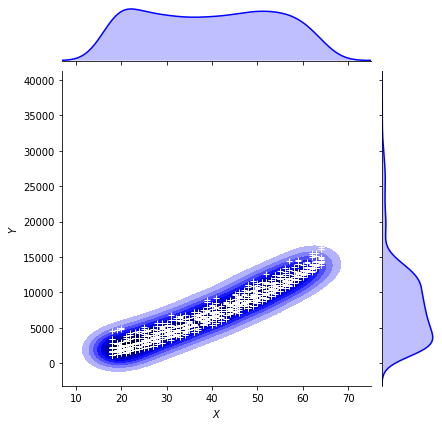

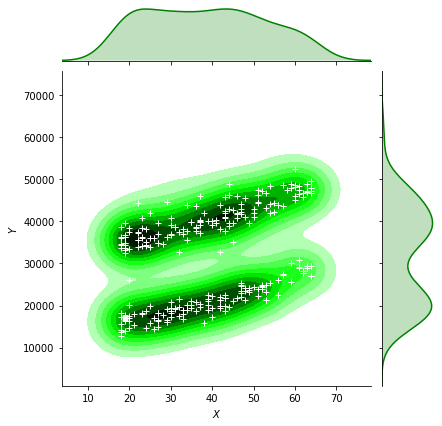

In [21]:
#plotando a relação entre idade X fumante 
g = sns.jointplot(x="idade", y="custos", data = df[(df.fumante == 0)],kind="kde", color="b")
g.plot_joint(pl.scatter, c="w", s=30, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$X$", "$Y$")
ax.set_title('Distribuição de custos e idade para não fumantes')


g = sns.jointplot(x="idade", y="custos", data = df[(df.fumante == 1)],kind="kde", color="g")
g.plot_joint(pl.scatter, c="w", s=30, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$X$", "$Y$")
ax.set_title('Distribuição de custos e idade para fumantes')

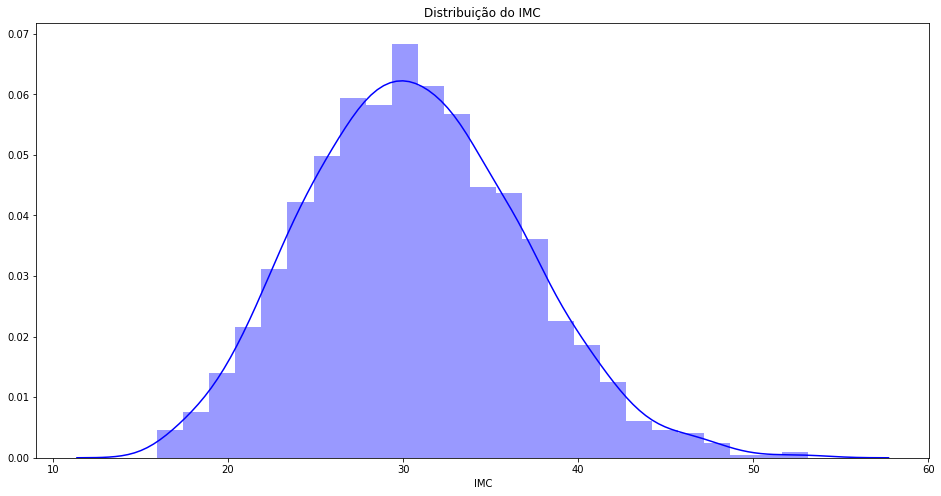

In [22]:
#plotando a distribuição do IMC
pl.figure(figsize=(16,8))
pl.title("Distribuição do IMC")
ax = sns.distplot(df["IMC"], color = 'b')

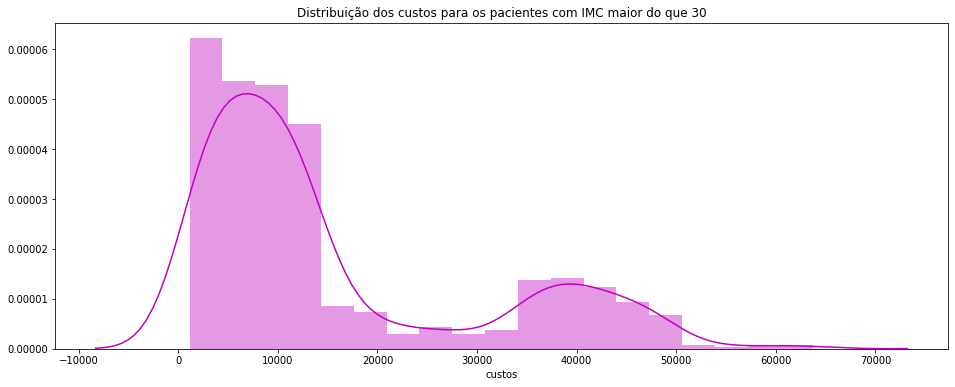

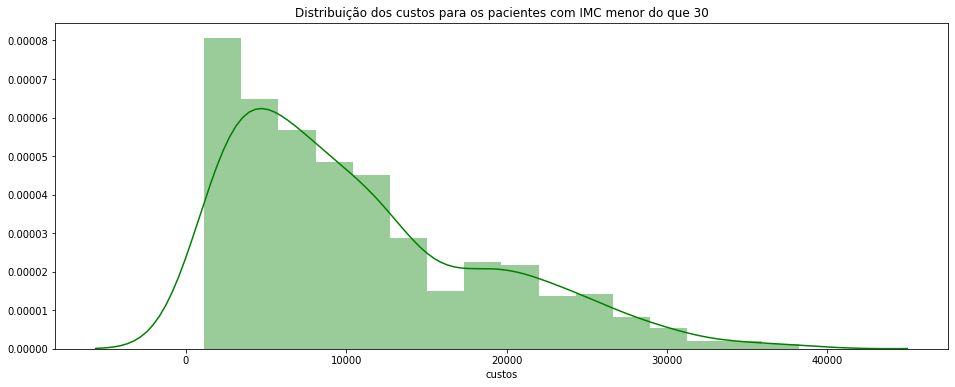

In [23]:
#plotando os custos para pacientes com IMC maior do que 30
pl.figure(figsize=(16,6))
pl.title("Distribuição dos custos para os pacientes com IMC maior do que 30")
ax = sns.distplot(df[(df.IMC >= 30)]['custos'], color = 'm')

pl.figure(figsize=(16,6))
pl.title("Distribuição dos custos para os pacientes com IMC menor do que 30")
ax = sns.distplot(df[(df.IMC < 30)]['custos'], color = 'g')

Text(0.5, 1, 'Distribuição dos custos por IMC')

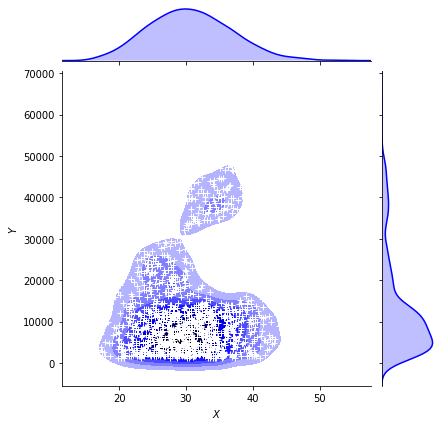

In [24]:
#parece que os pacientes com IMC acima de 30 gastam mais, vamos plotar
g = sns.jointplot(x="IMC", y="custos", data = df,kind="kde", color="b")
g.plot_joint(pl.scatter, c="w", s=30, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$X$", "$Y$")
ax.set_title("Distribuição dos custos por IMC")

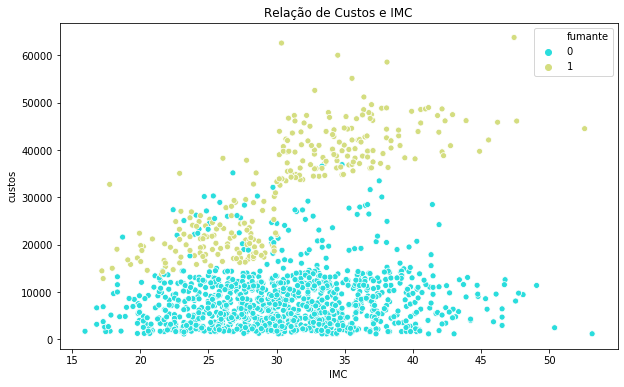

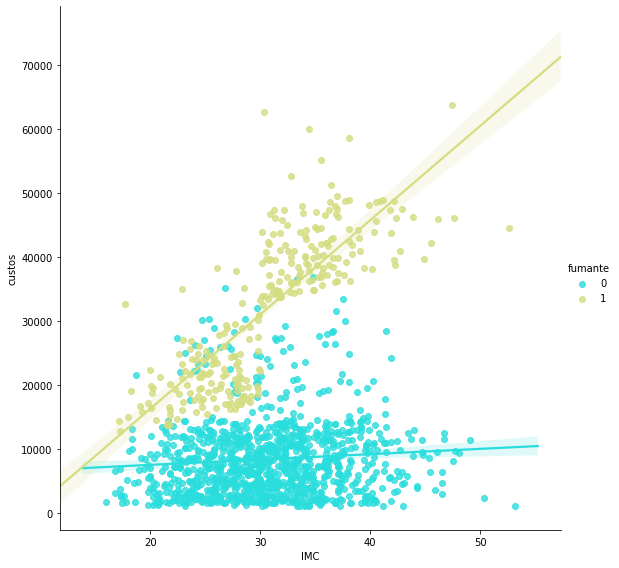

In [25]:
#plotando custos por IMC
pl.figure(figsize=(10,6))
ax = sns.scatterplot(x='IMC',y='custos',data = df,palette='rainbow',hue='fumante')
ax.set_title('Relação de Custos e IMC')

sns.lmplot(x="IMC", y="custos", hue="fumante", data = df, palette = 'rainbow', size = 8)

## Parte 3 - Regressão

Nessa fase, tentaremos fazer a previsão de quais variáveis estão mais relacionadas com altos custos médicos

In [31]:
#Inicialmente, decidimos aplicar um modelo de Random Forest, por se tratar de um modelo de regressão logística.
X = df.drop(['custos','regiao'], axis = 1)
Y = df.custos

quad = PolynomialFeatures (degree = 2)
x_quad = quad.fit_transform(X)

X_train,X_test,Y_train,Y_test = train_test_split(x_quad,Y, random_state = 0)

plr = RandomForestRegressor().fit(X_train,Y_train)

Y_train_pred = plr.predict(X_train)
Y_test_pred = plr.predict(X_test)

print(str('taxa de acurácia do modelo: ') + str(plr.score(X_test,Y_test)))

taxa de acurácia do modelo: 0.8488666685448115


In [0]:
# Validando a performance do algoritmo com o cálculo do erro residual. Para que as predições de uma regressão linear sejam confiáveis, é recomendado utilizar algum método
# de validação. Nesse caso, utilizamos o erro quadrático médio. Os scores desse erro servirão para comparar a performance do algoritmo na base de teste e na base de treino,
# sempre priorizando as menores variâncias, ou valores. No caso do R², ou coeficiente de determinação, buscamos um valor mais aproximado de 1, que indica que a variável que
# queremos prever consegue ser explicada pelo modelo.

forest = RandomForestRegressor(n_estimators = 100,
                              criterion = 'mse',
                              random_state = 1,
                              n_jobs = -1)
forest.fit(X_train,Y_train)
forest_train_pred = forest.predict(X_train)
forest_test_pred = forest.predict(X_test)

print('MSE treino: %.3f , MSE teste: %.3f' % (
mean_squared_error(Y_train,forest_train_pred),
mean_squared_error(Y_test,forest_test_pred)))
print('R2 treino: %.3f, R2 teste: %.3f' % (
r2_score(Y_train,forest_train_pred),
r2_score(Y_test,forest_test_pred)))

MSE treino: 3969212.165 , MSE teste: 20081745.321
R2 treino: 0.972, R2 teste: 0.872


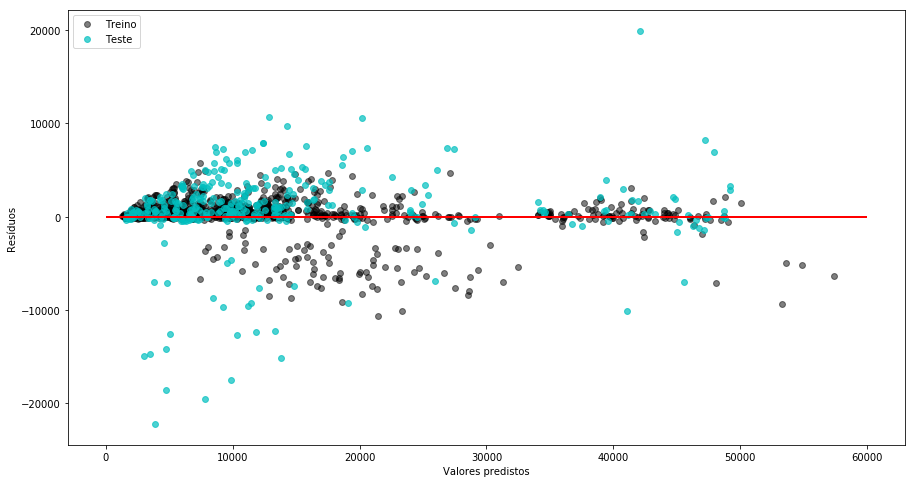

In [0]:
#plotando os resultados dos valores da previsão
pl.figure(figsize=(15,8))

pl.scatter(forest_train_pred,forest_train_pred - Y_train,
          c = 'black', marker = 'o', s = 35, alpha = 0.5,
          label = 'Treino')
pl.scatter(forest_test_pred,forest_test_pred - Y_test,
          c = 'c', marker = 'o', s = 35, alpha = 0.7,
          label = 'Teste')
pl.xlabel('Valores predistos')
pl.ylabel('Resíduos')
pl.legend(loc = 'upper left')
pl.hlines(y = 0, xmin = 0, xmax = 60000, lw = 2, color = 'red')
pl.show()